# Анализ лояльности пользователей Яндекс Афиши

### Цели и задачи проекта 

**Цель:** Анализ лояльности пользователей Яндекс Афиши, чтобы удерживать и превращать клиентов в в постоянных

**Задачи:**
1. Загрузка данных и знакомство с ними
2. Предобработка данных
3. Создание профилья
4. Исследовательский анализ данных
5. Итоговый вывод и рекомендации
6. Финализация проекта

**Описание**

Команда маркетинга хочет лучше понимать поведение пользователей. Для этого они просят вас провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Это позволит:
- Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
- Оптимизировать маркетинговые бюджеты.
- Повысить общий уровень удержания клиентов.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install sqlalchemy

In [2]:
!pip install psycopg2-binary

In [3]:
import pandas as pd
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

query = '''
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name, 
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
''' 

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [6]:
df = pd.read_sql_query(query, con=engine) 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край


**Промежуточный вывод** 

Датасет содержит 290 611 записей о покупках билетов пользователей. Все ключевые поля заполнены, за исключением признака days_since_prev (количество дней с момента предыдущей покупки), где есть пропуски у части клиентов — что говорит о том, что это их первая покупка.

Типы данных корректны: даты представлены в формате datetime64, числовые поля (revenue, tickets_count, days_since_prev) — в числовом формате, категориальные признаки (device_type_canonical, event_type_main, service_name, city_name, region_name) имеют тип object.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [7]:
currency = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
display(currency.head())
currency.info()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [8]:
currency['data'] = pd.to_datetime(currency['data'])

df = df.merge(currency[['data', 'curs']], left_on='order_dt', right_on='data', how='left')
df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,data,curs
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,2024-08-20,18.6972
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион,2024-07-23,18.3419
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион,2024-10-06,19.6475
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область,2024-07-13,18.5010
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край,2024-10-04,19.6648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион,2024-10-27,19.9266
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион,2024-10-27,19.9266
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Глиногорск,Каменевский регион,2024-10-30,19.9516
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Ягодиновка,Широковская область,2024-09-24,19.3967


In [9]:
def kz_curr(table):
    if table['currency_code'] == 'kzt':
        return table['revenue']*table['curs']/100
    else:
        return table['revenue']

df['revenue_rub'] = df.apply(kz_curr, axis=1)

df[df['currency_code']=='kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,data,curs,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Серебрянка,Верхоречная область,2024-09-17,19.0125,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Серебрянка,Верхоречная область,2024-09-02,18.9330,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Серебрянка,Верхоречная область,2024-09-09,18.5991,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Серебрянка,Верхоречная область,2024-06-11,19.8928,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Широковка,Шанырский регион,2024-06-04,19.9833,1478.296591


**Промежуточный вывод**

Выручка сервиса успешно приведена к единой валюте — российскому рублю.
Для этого данные о покупках были объединены с таблицей курсов тенге по дате заказа, после чего для операций в тенге выручка пересчитана в рубли с учётом курса за 100 тенге.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
    - Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [10]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,data,curs,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,2024-08-20,18.6972,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион,2024-07-23,18.3419,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион,2024-10-06,19.6475,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область,2024-07-13,18.5010,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край,2024-10-04,19.6648,1390.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион,2024-10-27,19.9266,1448.36
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион,2024-10-27,19.9266,965.57
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Глиногорск,Каменевский регион,2024-10-30,19.9516,178.95
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Ягодиновка,Широковская область,2024-09-24,19.3967,661.53


- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.

In [11]:
df[['order_id', 'revenue', 'tickets_count', 'days_since_prev', 'event_id', 'revenue_rub']].describe()

,order_id,revenue,tickets_count,days_since_prev,event_id,revenue_rub
count,2.906110e+05,290611.000000,290611.000000,268678.000000,290611.000000,290611.000000
mean,4.326225e+06,625.584360,2.754311,3.222381,438019.834992,555.571987
std,2.497551e+06,1227.693064,1.170620,11.350509,147423.078841,875.498172
min,1.000000e+00,-90.760000,1.000000,0.000000,4436.000000,-90.760000
25%,2.163618e+06,116.850000,2.000000,0.000000,361772.000000,113.970000
50%,4.326366e+06,356.010000,3.000000,0.000000,498275.000000,351.140000
75%,6.488330e+06,810.130000,4.000000,1.000000,546287.000000,802.050000
max,8.653108e+06,81174.540000,57.000000,148.000000,592325.000000,81174.540000


In [12]:
df['tickets_count'] = df['tickets_count'].astype('int8')
df['days_since_prev'] = df['days_since_prev'].astype('float16')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float16       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,data,curs,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,2024-08-20,18.6972,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион,2024-07-23,18.3419,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион,2024-10-06,19.6475,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область,2024-07-13,18.5010,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край,2024-10-04,19.6648,1390.41


- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
    - Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
    - Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

In [13]:
column_1 = ['device_type_canonical', 'currency_code', 'event_type_main']
column_2 = ['region_name', 'service_name', 'city_name']


for col in column_1:
    df[col] = df[col].str.lower()
    
for col in column_2:
    df[col] = df[col].str.lower()


for col in column_1:
    print(f"\n{col}:")
    print(df[col].value_counts(dropna=False))
    
for col in column_2:
    print(f"\n{col}:")
    print(df[col].value_counts(dropna=False).head(60))


device_type_canonical:
mobile     232490
desktop     58121
Name: device_type_canonical, dtype: int64

currency_code:
rub    285542
kzt      5069
Name: currency_code, dtype: int64

event_type_main:
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: event_type_main, dtype: int64

region_name:
каменевский регион           91058
североярская область         44049
широковская область          16457
медовская область            13901
озернинский край             10476
светополянский округ          7607
малиновоярский округ          6618
речиновская область           6293
солнечноземская область       6288
яблоневская область           6181
серебринская область          5610
горицветская область          5166
травяная область              5045
лугоградская область          4701
тепляковская область          4389
солнечнореченская область     3996
зоринский регион              3214
глиногорская область    

,tickets_count,days_since_prev,revenue_rub
count,290611.000000,268678.0,290611.000000
mean,2.754311,NaN,555.571987
std,1.170620,0.0,875.498172
min,1.000000,0.0,-90.760000
25%,2.000000,0.0,113.970000
50%,3.000000,0.0,351.140000
75%,4.000000,1.0,802.050000
max,57.000000,148.0,81174.540000


tickets_count столбец:


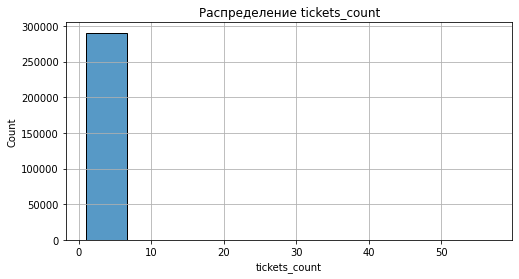

days_since_prev столбец:


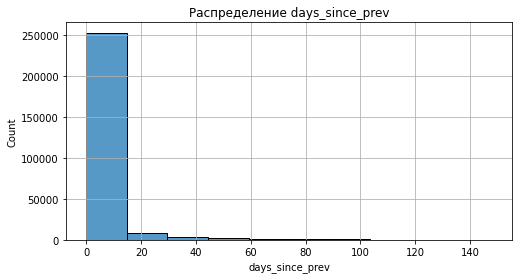

revenue_rub столбец:


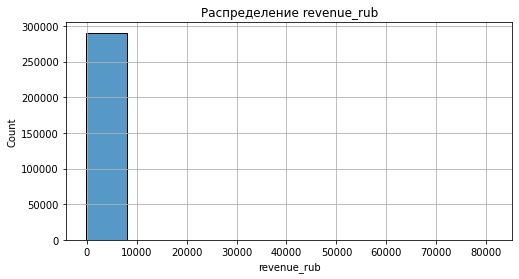

In [14]:
column_num = ['tickets_count', 'days_since_prev', 'revenue_rub']

display(df[column_num].describe())


for col in column_num:
    plt.figure(figsize=(8, 4))
    plt.grid(True)
    print(f'{col} столбец:')
    plt.title(f'Распределение {col}')
    sns.histplot(data=df, x=col, bins=10)
    plt.show()

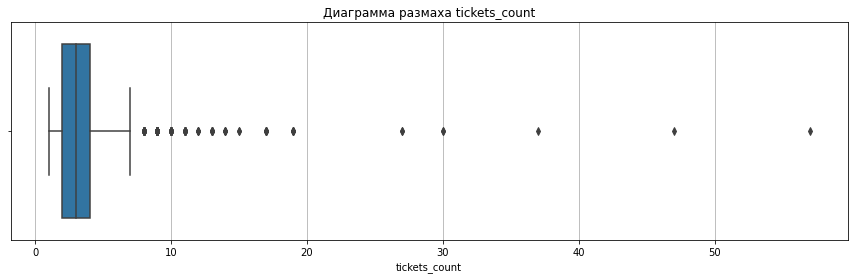

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

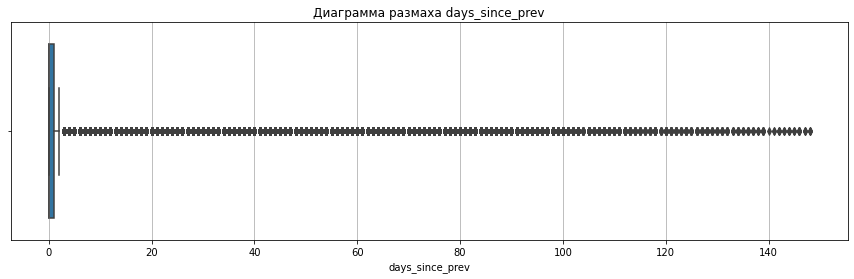

count    268678.0
mean          NaN
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           1.0
max         148.0
Name: days_since_prev, dtype: float64

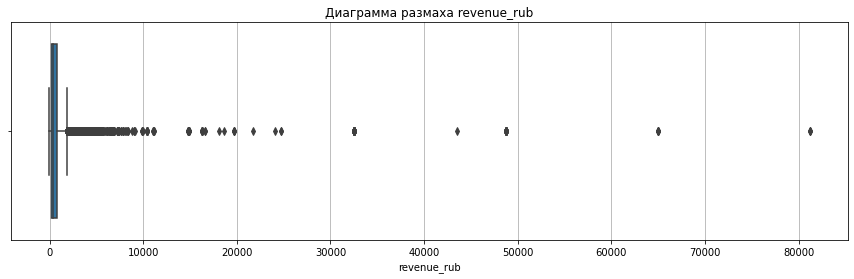

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

In [15]:
for col in column_num:
    plt.figure(figsize=(15, 4))
    plt.grid(True)
    sns.boxplot(data=df, x=col)
    plt.title(f'Диаграмма размаха {col}')
    plt.show()
    display(df[col].describe())

Данных после фильтрации: 287786 строк


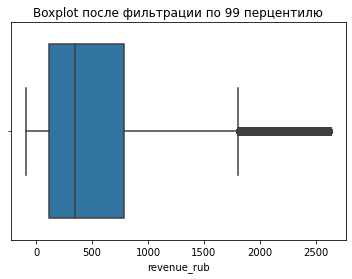

count    287786.000000
mean        518.029224
std         511.963780
min         -90.760000
25%         111.850000
50%         343.850000
75%         788.660000
max        2628.421739
Name: revenue_rub, dtype: float64

In [16]:
p99 = df['revenue_rub'].quantile(0.99)
df = df[df['revenue_rub'] <= p99]

print(f"Данных после фильтрации: {len(df)} строк")

sns.boxplot(x=df['revenue_rub'])
plt.title('Boxplot после фильтрации по 99 перцентилю')
plt.show()

display(df['revenue_rub'].describe())

**Промежуточный вывод** 

- Пропуски наблюдаются только в столбце days_since_prev (268 678 из 290 611 строк), что соответствует логике данных: для первого заказа пользователя нет предыдущего заказа.
- Типы данных скорректированы для оптимизации памяти: даты — datetime64, tickets_count на int8, days_since_prev на float16.
- Категориальные столбцы нормализованы (нижний регистр) для единообразия: device_type_canonical, currency_code, event_type_main, region_name, service_name, city_name. Пропусков и категорий, обозначающих отсутствие информации, не обнаружено.

Распределение числовых данных:
- tickets_count — большинство заказов содержит 1–5 билетов, редкие крупные заказы до 57 билетов;
- revenue_rub — выявлены выбросы (максимум 81 174 руб.), после фильтрации по 99 перцентилю осталось 287 786 строк, среднее значение 518 руб.;
- days_since_prev — значения адекватны, тип данных сохранён как float16.

Основные показатели для анализа (выручка и количество билетов) очищены и подготовлены для дальнейшей работы: анализ распределения, выявление закономерностей и построение сегментаций.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [17]:
df = df.sort_values(by='order_dt')
first_order = df.groupby('user_id').first()[[ 
    'device_type_canonical',
    'region_name', 
    'service_name', 
    'event_type_main']].reset_index()

user_profile = df.groupby('user_id').agg(
first_order_date = ('order_dt', 'min'),
last_order_date = ('order_dt', 'max'), 
total_orders=('order_id', 'nunique'),
avg_revenue = ('revenue_rub', 'mean'),
avg_tickets = ('tickets_count', 'mean'),
avg_time_between_orders=('days_since_prev', 'mean')
)

user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

user_profile = user_profile.merge(first_order, on='user_id', how='left')
user_profile

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,device_type_canonical,region_name,service_name,event_type_main
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN,0,0,mobile,каменевский регион,край билетов,театр
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.000,1,0,mobile,каменевский регион,мой билет,выставки
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.000,1,0,mobile,североярская область,лови билет!,другое
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN,0,0,desktop,каменевский регион,край билетов,театр
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.000,1,0,mobile,поленовский край,лучшие билеты,театр
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21849,fff13b79bd47d7c,2024-07-16,2024-10-31,9,688.043333,2.555556,13.375,1,1,mobile,каменевский регион,мой билет,другое
21850,fff32fc9ad0f9f6,2024-08-15,2024-10-28,2,850.995000,2.500000,74.000,1,0,desktop,каменевский регион,билеты без проблем,стендап
21851,fffcd3dde79eb2c,2024-06-20,2024-10-30,33,557.908485,2.787879,4.125,1,1,desktop,каменевский регион,билеты без проблем,концерты
21852,fffeeb3c120cf0b,2024-09-24,2024-09-24,1,661.530000,2.000000,NaN,0,0,desktop,широковская область,билеты без проблем,стендап


**Промежуточный вывод**

- Определены даты первого и последнего заказа, а также устройство, регион, сервис и жанр первого заказа.
- Добавлены признаки is_two и is_five для пользователей с ≥2 и ≥5 заказами.
- Рассчитаны средняя выручка (avg_revenue), среднее количество билетов (avg_tickets) и среднее время между заказами (avg_time_between_orders).
- Данные категориальных признаков чистые, агрегированные показатели рассчитаны корректно, профиль готов для дальнейшего анализа и сегментации.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [18]:
display(user_profile.head())
user_profile.info()

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,device_type_canonical,region_name,service_name,event_type_main
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN,0,0,mobile,каменевский регион,край билетов,театр
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.0,1,0,mobile,каменевский регион,мой билет,выставки
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.0,1,0,mobile,североярская область,лови билет!,другое
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN,0,0,desktop,каменевский регион,край билетов,театр
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.0,1,0,mobile,поленовский край,лучшие билеты,театр


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21854 entries, 0 to 21853
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21854 non-null  object        
 1   first_order_date         21854 non-null  datetime64[ns]
 2   last_order_date          21854 non-null  datetime64[ns]
 3   total_orders             21854 non-null  int64         
 4   avg_revenue              21854 non-null  float64       
 5   avg_tickets              21854 non-null  float64       
 6   avg_time_between_orders  13513 non-null  float16       
 7   is_two                   21854 non-null  int64         
 8   is_five                  21854 non-null  int64         
 9   device_type_canonical    21854 non-null  object        
 10  region_name              21854 non-null  object        
 11  service_name             21854 non-null  object        
 12  event_type_main          21854 n

In [19]:
display('Общее число пользователей в выборке:', user_profile['user_id'].nunique())

'Общее число пользователей в выборке:'

21854

In [20]:
print('Cредняя выручка с одного заказа')

round((user_profile['avg_revenue']*user_profile['total_orders']).sum()/user_profile['total_orders'].sum(), 2)

Cредняя выручка с одного заказа


518.03

In [21]:
share_two = user_profile['is_two'].mean().round(2)
share_five = user_profile['is_five'].mean().round(2)

print('Доля пользователей совершивших 2 и более заказа:', share_two)
print('Доля пользователей совершивших 5 и более заказа:', share_five)

Доля пользователей совершивших 2 и более заказа: 0.62
Доля пользователей совершивших 5 и более заказа: 0.29


In [22]:
display(user_profile['total_orders'].describe())

display(user_profile['avg_tickets'].describe())

display(user_profile['avg_time_between_orders'].describe())

count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: total_orders, dtype: float64

count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: avg_tickets, dtype: float64

count    1.351300e+04
mean              inf
std      2.231250e+01
min      0.000000e+00
25%      1.000000e+00
50%      8.000000e+00
75%      2.042188e+01
max      1.480000e+02
Name: avg_time_between_orders, dtype: float64

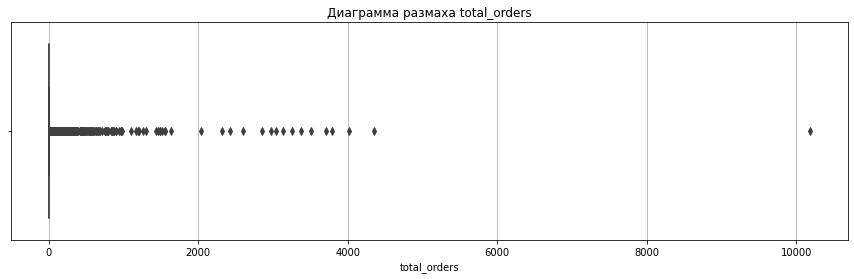

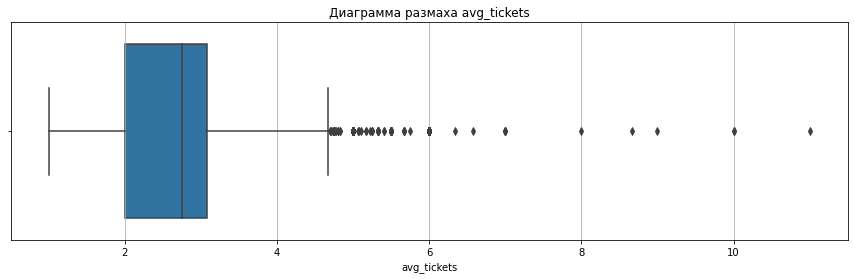

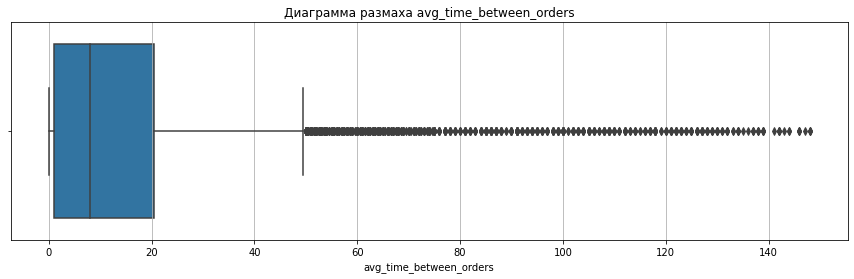

In [23]:
column_3 = ['total_orders', 'avg_tickets', 'avg_time_between_orders']

for col in column_3:
    plt.figure(figsize=(15, 4))
    plt.grid(True)
    sns.boxplot(data=user_profile, x=col)
    plt.title(f'Диаграмма размаха {col}')
    plt.show()

In [24]:
print('Cтатистические показатели по общему числу заказов')
print(user_profile['total_orders'].quantile([0.95, 0.99]))
print()
print('Cтатистические показатели по среднему числу билетов в заказе')
print(user_profile['avg_tickets'].quantile([0.95, 0.99]))
print()
print('Cтатистические показатели по среднему количеству дней между покупками')
print(user_profile['avg_time_between_orders'].quantile([0.95, 0.99]))

Cтатистические показатели по общему числу заказов
0.95     31.35
0.99    152.00
Name: total_orders, dtype: float64

Cтатистические показатели по среднему числу билетов в заказе
0.95    4.0
0.99    5.0
Name: avg_tickets, dtype: float64

Cтатистические показатели по среднему количеству дней между покупками
0.95     61.5
0.99    112.0
Name: avg_time_between_orders, dtype: float16


In [25]:
user_profile = user_profile[
    (user_profile['total_orders'] <= user_profile['total_orders'].quantile(0.95))]

display(user_profile['total_orders'].describe())
display(user_profile)

count    20761.000000
mean         4.049564
std          5.113359
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         31.000000
Name: total_orders, dtype: float64

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,device_type_canonical,region_name,service_name,event_type_main
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN,0,0,mobile,каменевский регион,край билетов,театр
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.000,1,0,mobile,каменевский регион,мой билет,выставки
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.000,1,0,mobile,североярская область,лови билет!,другое
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN,0,0,desktop,каменевский регион,край билетов,театр
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.000,1,0,mobile,поленовский край,лучшие билеты,театр
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21848,ffed3ff067d4f12,2024-07-31,2024-10-17,4,50.515000,2.250000,26.000,1,0,mobile,малиновая область,лучшие билеты,другое
21849,fff13b79bd47d7c,2024-07-16,2024-10-31,9,688.043333,2.555556,13.375,1,1,mobile,каменевский регион,мой билет,другое
21850,fff32fc9ad0f9f6,2024-08-15,2024-10-28,2,850.995000,2.500000,74.000,1,0,desktop,каменевский регион,билеты без проблем,стендап
21852,fffeeb3c120cf0b,2024-09-24,2024-09-24,1,661.530000,2.000000,NaN,0,0,desktop,широковская область,билеты без проблем,стендап


**Промежуточный вывод** 
- Общее число пользователей: 21 854, после фильтрации аномалий по 95 перцентилю по количеству заказов осталось 20 761 пользователя.
- Средняя выручка с одного заказа: 518 руб.
- Доля пользователей с ≥2 заказами: 62%, с ≥5 заказами: 29%.
- Статистический анализ выявил аномальные значения: несколько пользователей имеют экстремально большое число заказов (до 10 181) и большое среднее время между покупками (макс. 1480 дней), что не характерно для основной массы пользователей.
- Среднее количество билетов в заказе в основном в диапазоне 1–5, экстремальные значения до 11 билетов встречаются редко.
- Фильтрация по 95 перцентилю позволила убрать выбросы по числу заказов, сохранив репрезентативность данных и уменьшив риск искажений при дальнейшем анализе.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [26]:
analyze_column = ['event_type_main', 'device_type_canonical', 'region_name', 'service_name']

for category_type in analyze_column:
    event_ratio = user_profile.groupby(category_type)['user_id'].count().sort_values(ascending=False).reset_index()
    event_ratio['persentage %'] = round(100*event_ratio['user_id']/event_ratio['user_id'].sum(), 3)
    display(f"Распределение по признаку: {category_type}")
    display(event_ratio.head(10))

'Распределение по признаку: event_type_main'

,event_type_main,user_id,persentage %
0,концерты,9192,44.275
1,другое,5182,24.960
2,театр,4062,19.566
3,стендап,1065,5.130
4,спорт,768,3.699
5,выставки,399,1.922
6,ёлки,93,0.448


'Распределение по признаку: device_type_canonical'

,device_type_canonical,user_id,persentage %
0,mobile,17202,82.857
1,desktop,3559,17.143


'Распределение по признаку: region_name'

,region_name,user_id,persentage %
0,каменевский регион,6767,32.595
1,североярская область,3605,17.364
2,широковская область,1195,5.756
3,озернинский край,655,3.155
4,малиновоярский округ,512,2.466
5,травяная область,469,2.259
6,шанырский регион,461,2.221
7,светополянский округ,434,2.090
8,речиновская область,421,2.028
9,яблоневская область,398,1.917


'Распределение по признаку: service_name'

,service_name,user_id,persentage %
0,билеты без проблем,4959,23.886
1,мой билет,2848,13.718
2,лови билет!,2710,13.053
3,билеты в руки,2426,11.685
4,облачко,2110,10.163
5,весь в билетах,1239,5.968
6,лучшие билеты,1134,5.462
7,прачечная,548,2.640
8,край билетов,436,2.100
9,дом культуры,336,1.618


**Промежуточный вывод**

- По типу первого мероприятия: пользователи распределены неравномерно. Наибольшая доля — концерты (44%), далее «другое» (25%) и театр (20%). Остальные категории (<6%) значительно меньше представлены.
- По типу устройства: явный перевес мобильных пользователей — 83% делают первые покупки с мобильных, 17% с десктопа.
- По региону: распределение также неравномерное. Лидирует каменевский регион (33%), за ним идут североярская область (17%) и широковская область (6%). Остальные регионы имеют менее 4% пользователей.
- По билетному оператору: «билеты без проблем» обслуживают 24% пользователей, далее «мой билет» (14%) и «лови билет!» (13%). Остальные операторы имеют меньшую долю (<12%).

В данных есть явные «точки входа» — популярные сегменты по типу мероприятия, устройству, региону и оператору. Распределение пользователей неравномерное, что важно учитывать при дальнейшей сегментации и анализе поведения.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


'Возвраты по сегменту: event_type_main'

,event_type_main,total_users,repeat_users,return_rate
0,выставки,399,250,0.626566
5,театр,4062,2510,0.617922
2,концерты,9192,5543,0.603024
4,стендап,1065,631,0.592488
1,другое,5182,2991,0.577190
6,ёлки,93,51,0.548387
3,спорт,768,417,0.542969


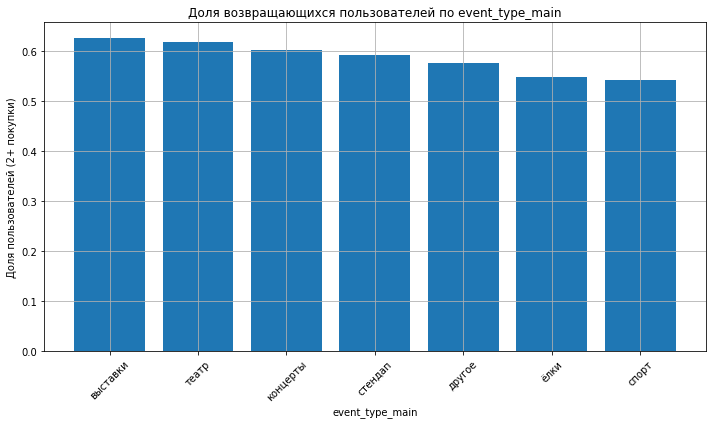

'Возвраты по сегменту: device_type_canonical'

,device_type_canonical,total_users,repeat_users,return_rate
0,desktop,3559,2215,0.622366
1,mobile,17202,10178,0.591675


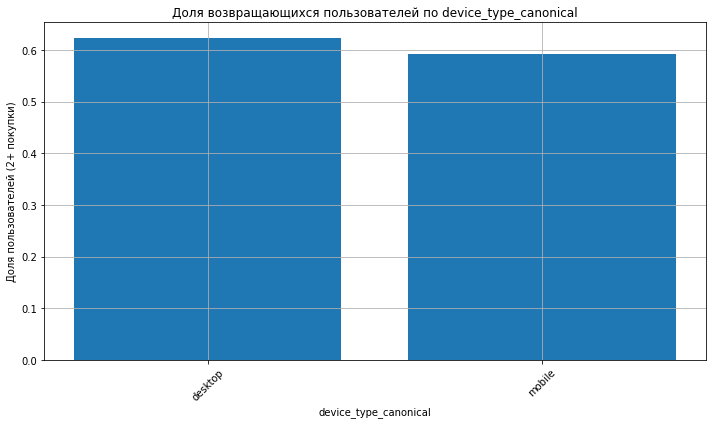

'Возвраты по сегменту: region_name'

,region_name,total_users,repeat_users,return_rate
5,верхозёрский край,1,1.0,1.000000
46,озернопольская область,26,23.0,0.884615
51,радужнопольский край,21,16.0,0.761905
71,тихолесский край,10,7.0,0.700000
36,лесостепной край,55,38.0,0.690909
33,лесноярский край,3,2.0,0.666667
79,ягодиновская область,61,40.0,0.655738
12,горноземский регион,26,17.0,0.653846
76,шанырский регион,461,297.0,0.644252
11,горицветская область,230,148.0,0.643478


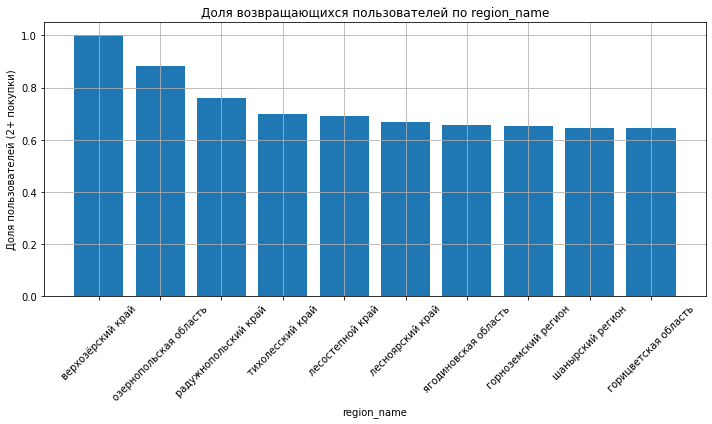

'Возвраты по сегменту: service_name'

,service_name,total_users,repeat_users,return_rate
14,зе бест!,1,1,1.000000
6,быстрый кассир,55,46,0.836364
2,билет по телефону,6,5,0.833333
26,реестр,27,21,0.777778
8,восьмёрка,83,56,0.674699
0,crazy ticket!,42,28,0.666667
1,show_ticket,156,101,0.647436
17,край билетов,436,278,0.637615
27,росбилет,38,24,0.631579
10,выступления.ру,97,61,0.628866


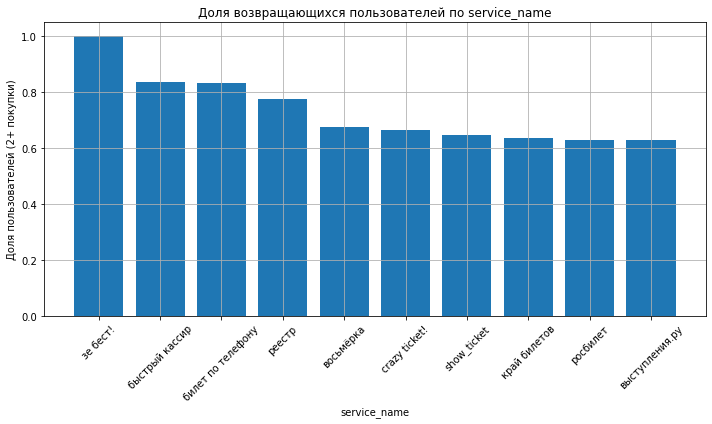

In [27]:
for category_type in analyze_column:
    total_users = user_profile.groupby(category_type)['user_id'].nunique().reset_index(name='total_users')
    two_more_users = user_profile[user_profile['is_two']==1].groupby(category_type)['user_id'].nunique().reset_index(name='repeat_users')
    merged = total_users.merge(two_more_users, on=category_type, how='left').fillna(0)
    merged['return_rate'] = merged['repeat_users'] / merged['total_users']
    merged = merged.sort_values('return_rate', ascending=False)
    top10 = merged.head(10)
    display(f"Возвраты по сегменту: {category_type}")
    display(top10)
    

    plt.figure(figsize=(10, 6))
    plt.bar(top10[category_type], top10['return_rate'])
    plt.title(f'Доля возвращающихся пользователей по {category_type}')
    plt.xlabel(category_type)
    plt.ylabel('Доля пользователей (2+ покупки)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Промежуточный вывод**

- По типу первого мероприятия: пользователи выставок (62,7%) и театра (61,8%) чаще возвращаются, чем в среднем по выборке (62%). Наименее склонны к повторным заказам — пользователи спорта и «ёлок» (<55%).
- По типу устройства: десктопные пользователи возвращаются чаще (62%) по сравнению с мобильными (59%).
- По региону: в лидерах по доле возвратов — малые регионы с небольшой базой пользователей (например, верхозёрский край 100%, озернопольская область 88%), что может быть статистически нестабильно. Среди крупных регионов высокая активность наблюдается в шанырском регионе (64%).
- По билетному оператору: наибольший процент повторных покупок у небольших операторов с ограниченной базой (например, «зе бест!» 100%, «быстрый кассир» 84%), среди крупных операторов — «край билетов» 64%, «выступления.ру» 63%.

Успешные «точки входа» наблюдаются у определённых типов мероприятий (выставки, театр) и у десктопных пользователей. При оценке регионов и операторов важно учитывать размер сегмента: маленькие сегменты дают высокие доли возвратов, но могут быть статистически ненадёжными. Наибольший стабильный эффект виден среди крупных сегментов с высокой долей возвратов.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1: «Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие первый заказ на концерты».**

Результаты анализа:

Доля возвращающихся пользователей по типу мероприятия:

- Спорт — 54,3%
- Концерты — 60,3%

Вывод: пользователи спортивных мероприятий возвращаются реже, чем пользователи концертов.
Гипотеза 1 — не подтверждается.

**Гипотеза 2: «В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах».**

Результаты анализа:

Самые крупные регионы по числу пользователей:

- Каменевский регион — 6 767 пользователей
- Североярская область — 3 605 пользователей

Доля возвращающихся пользователей в крупных регионах:
- Шанырский регион — 64,4% (средний по топ-10)
- Горноземский регион — 65,4%
- В отдельных небольших регионах доля возвратов может быть выше (например, верхозёрский край 100%), но это нестабильно из-за малой выборки.

Вывод: в крупных регионах доля повторных заказов не всегда выше, чем в менее активных. Высокая активность в малых сегментах может создавать впечатление больших возвратов, но это статистически ненадёжно.
Гипотеза 2 — не подтверждается в целом.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


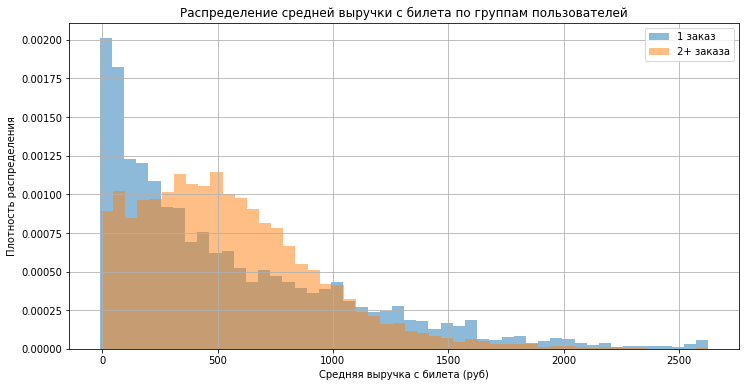

In [28]:
one_order = user_profile[user_profile['is_two'] == 0]
repeat = user_profile[user_profile['is_two'] == 1]

plt.figure(figsize=(12,6))
plt.hist(one_order['avg_revenue'], alpha=0.5, bins=50, density=True, label='1 заказ')
plt.hist(repeat['avg_revenue'], alpha=0.5, bins=50, density=True, label='2+ заказа')
plt.xlabel('Средняя выручка с билета (руб)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с билета по группам пользователей')
plt.legend()
plt.grid(True)
plt.show()

**Промежуточный вывод**
- Пользователи, совершившие только один заказ, в основном сосредоточены в диапазоне низкой средней выручки — до ~500 рублей за билет.
- Пользователи, совершившие 2 и более заказа, имеют более равномерное распределение выручки и чаще встречаются в диапазоне 200–1000 рублей, с небольшой долей более дорогих билетов.
- В целом, вернувшиеся пользователи склонны совершать более крупные заказы по выручке с билета, чем те, кто сделал только один заказ.
- Это говорит о том, что более высокие средние расходы на билет могут быть связаны с большей вовлечённостью и вероятностью повторного заказа.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


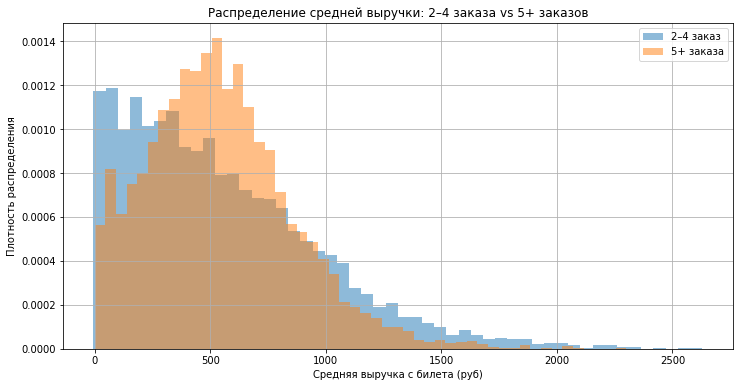

In [29]:
two_four = user_profile[(user_profile['is_two']==1)&(user_profile['is_five']==0)]
five_on = user_profile[user_profile['is_five']==1]


plt.figure(figsize=(12,6))
plt.hist(two_four['avg_revenue'], alpha=0.5, bins=50, density=True, label='2–4 заказ')
plt.hist(five_on['avg_revenue'], alpha=0.5, bins=50, density=True, label='5+ заказа')
plt.xlabel('Средняя выручка с билета (руб)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки: 2–4 заказа vs 5+ заказов')
plt.legend()
plt.grid(True)
plt.show()

**Промежуточный вывод**
- Пользователи, совершившие 2–4 заказа, в основном сосредоточены в диапазоне низкой средней выручки — до 500 рублей за билет.с небольшой долей более дорогих билетов. Большое количество приходится на 100-250 рублей.
- Пользователи, совершившие 5 и более заказа, имеют более нормальное распределение выручки и чаще встречаются в диапазоне 200–1000 рублей, где средняя (мат ожидание) приходится на 500 рублей. С небольшой долей более дорогих билетов.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [30]:
user_profile.head()

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,device_type_canonical,region_name,service_name,event_type_main
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN,0,0,mobile,каменевский регион,край билетов,театр
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.0,1,0,mobile,каменевский регион,мой билет,выставки
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.0,1,0,mobile,североярская область,лови билет!,другое
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN,0,0,desktop,каменевский регион,край билетов,театр
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.0,1,0,mobile,поленовский край,лучшие билеты,театр


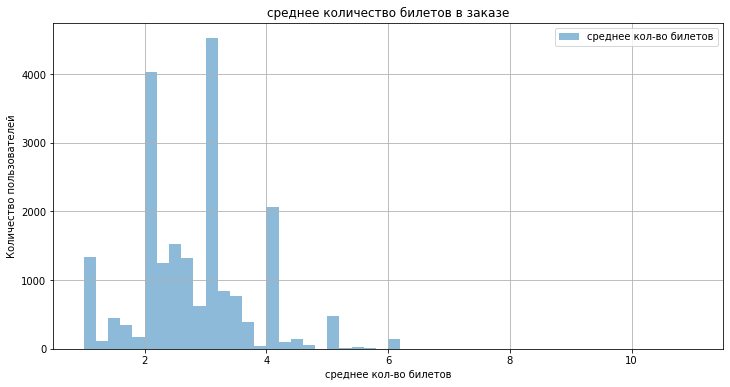

count    20761.000000
mean         2.743605
std          0.934540
min          1.000000
25%          2.000000
50%          2.750000
75%          3.150000
max         11.000000
Name: avg_tickets, dtype: float64

In [31]:
plt.figure(figsize=(12,6))
plt.hist(user_profile['avg_tickets'], alpha=0.5, bins=50, label='среднее кол-во билетов')
plt.xlabel('среднее кол-во билетов')
plt.ylabel('Количество пользователей')
plt.title('среднее количество билетов в заказе')
plt.legend()
plt.grid(True)
plt.show()

user_profile['avg_tickets'].describe()

In [32]:
def tickets_type(table):
    if table['avg_tickets'] <2:
        return 'от 1 до 2 билетов'
    elif 2 <= table['avg_tickets'] < 3:
        return 'от 2 до 3 билетов'
    elif 3<=table['avg_tickets'] <5:
        return 'от 3 до 5 билетов'
    else:
        return 'от 5 и более билетов'

user_profile = user_profile.copy()
user_profile['avg_tickets_type'] = user_profile.apply(tickets_type, axis=1)
user_profile.head()


,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,device_type_canonical,region_name,service_name,event_type_main,avg_tickets_type
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN,0,0,mobile,каменевский регион,край билетов,театр,от 3 до 5 билетов
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.0,1,0,mobile,каменевский регион,мой билет,выставки,от 3 до 5 билетов
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.0,1,0,mobile,североярская область,лови билет!,другое,от 2 до 3 билетов
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN,0,0,desktop,каменевский регион,край билетов,театр,от 3 до 5 билетов
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.0,1,0,mobile,поленовский край,лучшие билеты,театр,от 1 до 2 билетов


In [33]:
avg_tickets_type_count = user_profile.groupby('avg_tickets_type')['user_id'].count().reset_index(name='all_users')
repeat_avg_tickets_type_count = user_profile[user_profile['is_two']==1].groupby('avg_tickets_type')['user_id'].count().reset_index(name='repeated_users')
merged_tickets = avg_tickets_type_count.merge(repeat_avg_tickets_type_count, on='avg_tickets_type', how='left')
merged_tickets['return_rate'] = round(100*merged_tickets['repeated_users']/merged_tickets['all_users'], 2)


display(merged_tickets)

,avg_tickets_type,all_users,repeated_users,return_rate
0,от 1 до 2 билетов,2415,1237,51.22
1,от 2 до 3 билетов,8759,6250,71.36
2,от 3 до 5 билетов,8926,4782,53.57
3,от 5 и более билетов,661,124,18.76


**Промежуточный вывод**
1. Распределение пользователей по сегментам:
- Большинство пользователей сосредоточено в сегментах с 2–3 билетами (8759 пользователей) и 3–5 билетами (8926 пользователей).
- Сегмент «от 1 до 2 билетов» содержит 2415 пользователей, а сегмент «от 5 и более билетов» — всего 661 пользователя.
- Таким образом, распределение пользователей несбалансированное, с концентрацией в среднем диапазоне билетов (2–5 билетов).

2. Повторные покупки:
- Наибольшая доля повторных покупок наблюдается у пользователей с 2–3 билетами — 71,36%, что заметно выше среднего.
- Сегменты с 1–2 билетами и 3–5 билетами имеют примерно сопоставимую долю повторных покупок — 51,22% и 53,57% соответственно.
- Наименьшая доля повторных покупок — у пользователей с 5 и более билетами — 18,76%, что выглядит аномально низким.

Пользователи с небольшим или средним количеством билетов (2–3) чаще возвращаются, в то время как покупатели крупных заказов (5+) гораздо реже совершают повторные покупки. Это может указывать на то, что крупные заказы совершаются эпизодически, а средние — регулярнее.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [34]:
user_profile['day_of_week'] = pd.to_datetime(user_profile['first_order_date']).dt.day_name()

weekday = user_profile.groupby('day_of_week')['user_id'].count().reset_index(name='all_users')

repeat_weekday = user_profile[user_profile['is_two']==1].groupby('day_of_week')['user_id'].count().reset_index(name='repeated_users')
merged_weekday = weekday.merge(repeat_weekday, on='day_of_week', how='left')
merged_weekday['return_rate'] = round(100*merged_weekday['repeated_users']/merged_weekday['all_users'], 2)
merged_weekday = merged_weekday.sort_values(by='return_rate', ascending=False)


display(merged_weekday)

,day_of_week,all_users,repeated_users,return_rate
1,Monday,2820,1737,61.60
6,Wednesday,2960,1804,60.95
2,Saturday,3122,1885,60.38
5,Tuesday,3025,1815,60.00
0,Friday,3166,1857,58.65
4,Thursday,3027,1764,58.28
3,Sunday,2641,1531,57.97


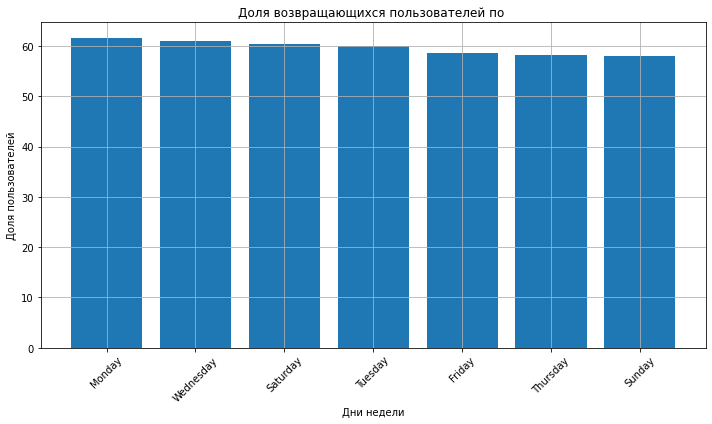

In [35]:
plt.figure(figsize=(10, 6))
plt.bar(merged_weekday['day_of_week'], merged_weekday['return_rate'])
plt.title('Доля возвращающихся пользователей по ')
plt.xlabel('Дни недели')
plt.ylabel('Доля пользователей')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Промежуточный вывод**
- Количество пользователей по дням недели распределено относительно равномерно, с небольшими колебаниями (от 2641 до 3166 пользователей).
- Наибольшая доля повторных покупок у пользователей, сделавших первую покупку в понедельник — 61,6%, наименьшая — в воскресенье — 57,97%.
- Разница в возврате клиентов по дням недели небольшая, но видно, что покупки в начале недели немного повышают вероятность повторного заказа.

День недели первой покупки влияет на вероятность возврата, но эффект умеренный.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [36]:
two_four = user_profile[(user_profile['is_two']==1)&(user_profile['is_five']==0)].copy()
five_on = user_profile[user_profile['is_five']==1].copy()

two_four['time_diff'] = (two_four['last_order_date'] - two_four['first_order_date']) / (two_four['total_orders'] - 1)
five_on['time_diff'] = (five_on['last_order_date'] - five_on['first_order_date']) / (five_on['total_orders'] - 1)

display(two_four['time_diff'])
display(five_on['time_diff'])

1       75 days 00:00:00
2       51 days 00:00:00
4       16 days 00:00:00
6        0 days 00:00:00
9       43 days 12:00:00
              ...       
21845    0 days 00:00:00
21846    0 days 00:00:00
21847   20 days 00:00:00
21848   26 days 00:00:00
21850   74 days 00:00:00
Name: time_diff, Length: 7147, dtype: timedelta64[ns]

5                  0 days 02:00:00
13                20 days 00:00:00
15       5 days 09:08:34.285714285
16                18 days 00:00:00
18      20 days 10:17:08.571428571
                   ...            
21832             21 days 06:00:00
21835    2 days 17:44:20.869565217
21838             17 days 00:00:00
21841    9 days 20:34:17.142857142
21849             13 days 09:00:00
Name: time_diff, Length: 5246, dtype: timedelta64[ns]

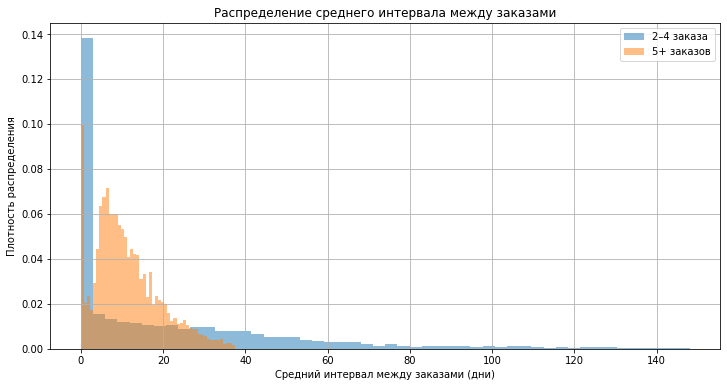

In [37]:
plt.figure(figsize=(12,6))

# Преобразуем timedelta в дни для удобства
two_four_days = two_four['time_diff'].dt.total_seconds() / 86400
five_on_days = five_on['time_diff'].dt.total_seconds() / 86400

# Построение гистограмм
plt.hist(two_four_days, bins=50, alpha=0.5, density=True, label='2–4 заказа')
plt.hist(five_on_days, bins=50, alpha=0.5, density=True, label='5+ заказов')

plt.xlabel('Средний интервал между заказами (дни)')
plt.ylabel('Плотность распределения')
plt.title('Распределение среднего интервала между заказами')
plt.legend()
plt.grid(True)
plt.show()

**Промежуточный вывод**
- Пользователи с 2–4 заказами имеют более широкий и смещённый в сторону больших значений интервалов между заказами, часть пользователей откладывает повторные покупки на 50–100 дней.
- Пользователи с 5 и более заказами совершают заказы чаще, с меньшими интервалами (обычно до 20–25 дней), распределение плотнее и концентрировано в нижнем диапазоне.

Чем короче средний интервал между заказами, тем выше вероятность удержания и совершения повторных покупок.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [38]:
user_profile.head()

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,device_type_canonical,region_name,service_name,event_type_main,avg_tickets_type,day_of_week
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN,0,0,mobile,каменевский регион,край билетов,театр,от 3 до 5 билетов,Tuesday
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.0,1,0,mobile,каменевский регион,мой билет,выставки,от 3 до 5 билетов,Tuesday
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.0,1,0,mobile,североярская область,лови билет!,другое,от 2 до 3 билетов,Saturday
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN,0,0,desktop,каменевский регион,край билетов,театр,от 3 до 5 билетов,Thursday
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.0,1,0,mobile,поленовский край,лучшие билеты,театр,от 1 до 2 билетов,Sunday


In [39]:
# Установка phik, если еще не установлена
!pip install phik

In [40]:
from phik import phik_matrix
interval_cols = ['total_orders', 'avg_revenue', 'avg_tickets', 'avg_time_between_orders']

cols_for_corr = ['total_orders', 'avg_revenue', 'avg_tickets', 'avg_time_between_orders', 
                 'is_two', 'is_five', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main']

df_corr = user_profile[cols_for_corr].copy()
corr_matrix = df_corr.phik_matrix(interval_cols=interval_cols)
display(corr_matrix)

,total_orders,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,device_type_canonical,region_name,service_name,event_type_main
total_orders,1.000000,0.265566,0.296873,0.490144,0.720260,0.986347,0.050899,0.015460,0.040156,0.028651
avg_revenue,0.265566,1.000000,0.453180,0.108586,0.293860,0.295455,0.077887,0.366409,0.385611,0.335143
avg_tickets,0.296873,0.453180,1.000000,0.092732,0.379596,0.337851,0.057784,0.171147,0.064132,0.096179
avg_time_between_orders,0.490144,0.108586,0.092732,1.000000,0.073535,0.448286,0.019153,0.093221,0.060272,0.054331
is_two,0.720260,0.293860,0.379596,0.073535,1.000000,0.681869,0.035179,0.072571,0.047672,0.031105
is_five,0.986347,0.295455,0.337851,0.448286,0.681869,1.000000,0.040684,0.066758,0.054577,0.023495
device_type_canonical,0.050899,0.077887,0.057784,0.019153,0.035179,0.040684,1.000000,0.112468,0.080538,0.061457
region_name,0.015460,0.366409,0.171147,0.093221,0.072571,0.066758,0.112468,1.000000,0.696577,0.506480
service_name,0.040156,0.385611,0.064132,0.060272,0.047672,0.054577,0.080538,0.696577,1.000000,0.587228
event_type_main,0.028651,0.335143,0.096179,0.054331,0.031105,0.023495,0.061457,0.506480,0.587228,1.000000


In [41]:
# Создаем сегменты
def orders_segment(row):
    if row['total_orders'] == 1:
        return '1 заказ'
    elif 2 <= row['total_orders'] <= 4:
        return '2–4 заказа'
    else:
        return '5+ заказов'

user_profile['orders_segment'] = user_profile.apply(orders_segment, axis=1)

In [42]:
interval_cols = ['total_orders', 'avg_revenue', 'avg_tickets', 'avg_time_between_orders']

cols_for_corr = ['total_orders', 'avg_revenue', 'avg_tickets', 'avg_time_between_orders', 
                 'is_two', 'is_five', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main']

for col in user_profile['orders_segment'].unique():
    df_corr = user_profile[user_profile['orders_segment']==col][cols_for_corr].copy()
    corr_matrix = df_corr.phik_matrix(interval_cols=interval_cols)
    display(f'коррелция для {col}', corr_matrix)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable total_orders for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(


'коррелция для 1 заказ'

,avg_revenue,avg_tickets,avg_time_between_orders,device_type_canonical,region_name,service_name,event_type_main
avg_revenue,1.000000,0.462853,0.000000,0.093222,0.402654,0.446405,0.380325
avg_tickets,0.462853,1.000000,0.000000,0.067936,0.196029,0.026385,0.111008
avg_time_between_orders,0.000000,0.000000,1.000000,0.000000,0.659041,0.549558,0.589333
device_type_canonical,0.093222,0.067936,0.000000,1.000000,0.096958,0.072233,0.061802
region_name,0.402654,0.196029,0.659041,0.096958,1.000000,0.668088,0.504971
service_name,0.446405,0.026385,0.549558,0.072233,0.668088,1.000000,0.580934
event_type_main,0.380325,0.111008,0.589333,0.061802,0.504971,0.580934,1.000000


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(


'коррелция для 2–4 заказа'

,total_orders,avg_revenue,avg_tickets,avg_time_between_orders,device_type_canonical,region_name,service_name,event_type_main
total_orders,1.000000,0.108758,0.369364,0.385223,0.006854,0.000000,0.053721,0.000000
avg_revenue,0.108758,1.000000,0.317216,0.175334,0.062101,0.323377,0.393180,0.328695
avg_tickets,0.369364,0.317216,1.000000,0.107131,0.048074,0.000000,0.000000,0.079607
avg_time_between_orders,0.385223,0.175334,0.107131,1.000000,0.036551,0.124937,0.080841,0.066116
device_type_canonical,0.006854,0.062101,0.048074,0.036551,1.000000,0.108945,0.068848,0.058324
region_name,0.000000,0.323377,0.000000,0.124937,0.108945,1.000000,0.683600,0.474716
service_name,0.053721,0.393180,0.000000,0.080841,0.068848,0.683600,1.000000,0.578463
event_type_main,0.000000,0.328695,0.079607,0.066116,0.058324,0.474716,0.578463,1.000000


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(


'коррелция для 5+ заказов'

,total_orders,avg_revenue,avg_tickets,avg_time_between_orders,device_type_canonical,region_name,service_name,event_type_main
total_orders,1.000000,0.163305,0.116416,0.712514,0.040613,0.071219,0.072712,0.044771
avg_revenue,0.163305,1.000000,0.344532,0.279886,0.069674,0.364114,0.279420,0.254692
avg_tickets,0.116416,0.344532,1.000000,0.158656,0.035018,0.179382,0.070001,0.118445
avg_time_between_orders,0.712514,0.279886,0.158656,1.000000,0.000000,0.174914,0.000000,0.127790
device_type_canonical,0.040613,0.069674,0.035018,0.000000,1.000000,0.151334,0.085344,0.065671
region_name,0.071219,0.364114,0.179382,0.174914,0.151334,1.000000,0.686294,0.528634
service_name,0.072712,0.279420,0.070001,0.000000,0.085344,0.686294,1.000000,0.573122
event_type_main,0.044771,0.254692,0.118445,0.127790,0.065671,0.528634,0.573122,1.000000


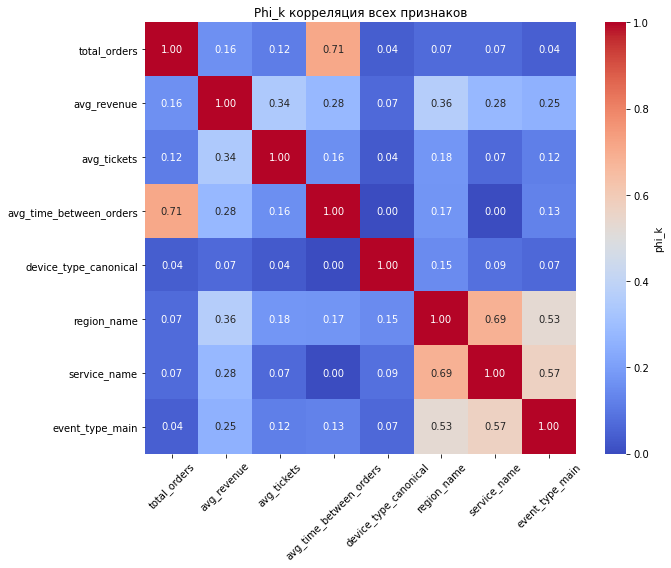

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'label': 'phi_k'})
plt.title('Phi_k корреляция всех признаков')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable total_orders for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(


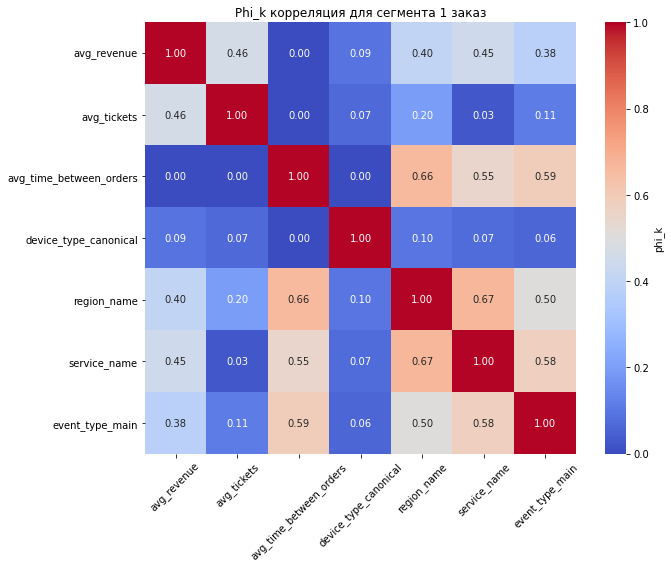

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(


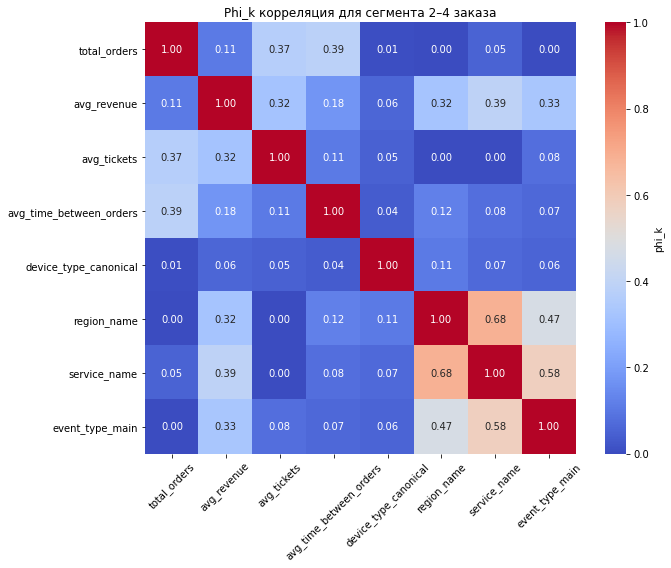

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(


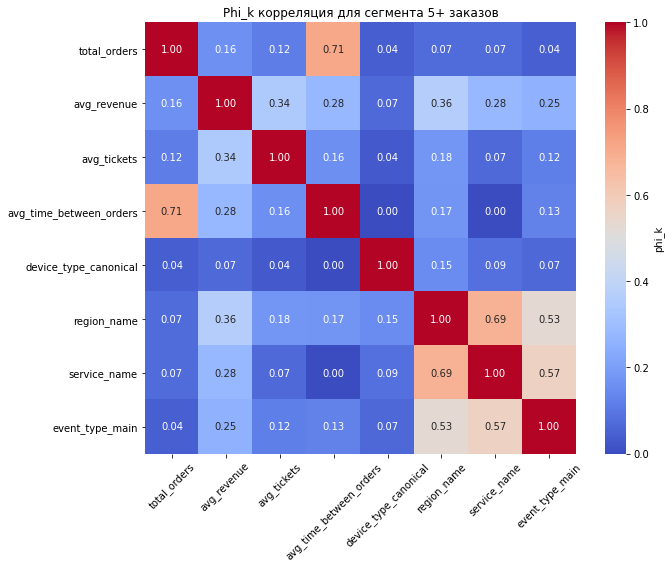

In [44]:
for seg in ['1 заказ', '2–4 заказа', '5+ заказов']:
    corr_seg = user_profile[user_profile['orders_segment']==seg][cols_for_corr].phik_matrix(
        interval_cols=['total_orders', 'avg_revenue', 'avg_tickets', 'avg_time_between_orders'])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_seg, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'label': 'phi_k'})
    plt.title(f'Phi_k корреляция для сегмента {seg}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

**Промежуточный вывод**

1. Корреляция всех пользователей (без сегментации)

Наиболее сильная связь с количеством заказов (total_orders) наблюдается у признаков:
- is_five (0.986) и is_two (0.720) — логично, т.к. эти бинарные признаки напрямую отражают число заказов.
- avg_time_between_orders (0.49) — чем больше средний интервал между заказами, тем выше корреляция с общим числом заказов.
- Слабая связь с категориальными признаками (device_type_canonical, region_name, service_name, event_type_main) — значения phi_k около 0.02–0.05, что говорит о слабой зависимости.

2. Сегмент «1 заказ»
- avg_time_between_orders не влияет (NaN/0) — логично, только один заказ.

Более заметная корреляция наблюдается у:
- region_name (0.66), service_name (0.67), event_type_main (0.59) — у пользователей с одним заказом география и тип сервиса могут определять выбор покупки.
- avg_revenue и avg_tickets — умеренная связь (0.46–0.46).

3. Сегмент «2–4 заказа»
- Сильной прямой связи с total_orders нет (0.10–0.38), что связано с меньшей вариацией признака.

Основная зависимость проявляется у:
- avg_tickets (0.37) и avg_time_between_orders (0.38) — пользователи с частыми заказами делают больше билетов за раз и чаще покупают.
- Категориальные признаки практически не связаны (phi_k около 0–0.05), за исключением service_name и region_name (0.32–0.68), что отражает влияние региона и сервиса на повторные заказы.

4. Сегмент «5+ заказов»

Наиболее сильная корреляция с total_orders у:
- avg_time_between_orders (0.71) — чем короче интервал между заказами, тем больше заказов в сегменте.
- Остальные признаки — умеренная связь (avg_revenue 0.16, avg_tickets 0.12, категориальные признаки <0.2), что говорит о том, что в этом сегменте больше влияние частоты заказов, чем географии или типа устройства.

Числовые признаки (avg_time_between_orders, avg_tickets, avg_revenue) и бинарные признаки (is_two, is_five) оказывают наибольшее влияние на количество заказов.

Категориальные признаки (device_type_canonical, region_name, service_name, event_type_main) имеют слабое влияние, но в сегменте «1 заказ» география и сервис важнее, чем в других сегментах.

Phi_k корректно показал зависимость как для числовых, так и категориальных признаков.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**5. Общий вывод и рекомендации**

**Информация о данных и их подготовка**

В рамках проекта был проведён анализ лояльности пользователей Яндекс Афиши. Исходные данные о покупках за 2024 год были выгружены из SQL-базы, объединены с информацией о мероприятиях, городах, регионах и курсами валют.

Ключевые этапы предобработки:
- Приведение к единой валюте: Выручка в казахстанских тенге была пересчитана в рубли по актуальному на дату заказа курсу.
- Очистка от выбросов: Для повышения репрезентативности данных были отфильтрованы аномально дорогие заказы (по 99-му перцентилю выручки) и пользователи с экстремально большим количеством заказов (по 95-му перцентилю).
- Оптимизация типов данных: Типы данных были изменены для сокращения потребления памяти (например, int8 для количества билетов).
- Создание профилей пользователей: Для каждого пользователя были сформированы агрегированные признаки, описывающие его поведение: история заказов, средние чеки, предпочтения по типам мероприятий и устройствам.
- После предобработки итоговая выборка для анализа составила 20 761 пользователя и 287 786 заказов.

**Основные результаты анализа**
1. Портрет и активность пользователей
- Распределение по заказам: 38% пользователей совершили только одну покупку, 62% — вернулись и сделали два и более заказа. По-настоящему лояльных клиентов с 5+ заказами — 29%.
- «Точки входа»: Большинство пользователей впервые приходят на платформу с мобильных устройств (83%), покупают билеты на концерты (44%) через сервис «Билеты без проблем» (24%), преимущественно из Каменевского региона (33%).

2. Признаки первого заказа, влияющие на возврат
- Тип мероприятия: Наибольшая лояльность у пользователей, чей первый заказ был на выставки (62.7% возвратов) и театральные постановки (61.8%). Посетители спортивных событий возвращаются реже (54.3%).
- Устройство: Пользователи, совершившие первую покупку с десктопа, возвращаются чаще (62.2%), чем те, кто начал с мобильного (59.2%).
- Билетный оператор: Среди крупных операторов высокий процент возврата демонстрируют «Край билетов» (64%) и «Выступления.ру» (63%).

3. Влияние финансовых и поведенческих метрик
- Средний чек: Пользователи с двумя и более заказами в среднем тратят больше. Их распределение расходов смещено в сторону более высокого ценового диапазона (200–1000 рублей), в то время как «одноразовые» клиенты концентрируются в сегменте до 500 рублей.
- Количество билетов: Наиболее лояльны пользователи, покупающие в среднем от 2 до 3 билетов за раз (71% возвратов). Парадоксально, но клиенты с самыми крупными заказами (5+ билетов) демонстрируют крайне низкую лояльность (19%), что говорит об эпизодическом, а не регулярном характере их покупок.

4. Временные характеристики
- День недели: День первой покупки оказывает умеренное, но заметное влияние. Наибольшая вероятность возврата у тех, кто совершил первый заказ в понедельник (61.6%), наименьшая — в воскресенье (58%).
- Частота покупок: Ключевой фактор удержания. Пользователи с 5+ заказами совершают их значительно чаще — средний интервал между их покупками редко превышает 20-25 дней. Для клиентов с 2-4 заказами этот интервал более широкий и может достигать 50-100 дней.

5. Результаты корреляционного анализа

Корреляционный анализ (φₖ) подтвердил, что количество заказов наиболее сильно связано с:
- Бинарными признаками (is_five, is_two) — что логично.
- Средним интервалом между заказами — короткие интервала коррелируют с большим числом покупок.
- Средним количеством билетов в заказе.
- Категориальные признаки (регион, тип мероприятия, оператор) имеют слабую прямую связь с общим числом заказов, но сильно влияют на сам факт первого и второго заказа.

**Рекомендации для команды маркетинга**
1. Упростите жизнь мобильным пользователям.
- Так как большинство заходит с телефонов, сделайте так, чтобы им было максимально удобно. Упростите процесс повторного заказа, добавьте персонализированные предложения прямо в мобильной версии или в приложении.

2. «Поймайте» после первой покупки.
- Самый важный момент — после первого заказа. Например, если человек сходил на выставку (а такие чаще возвращаются), тут же предложите ему похожие события или скидку на следующий поход. Это закрепит успех.

3. Работайте с разными группами по-разному.
- Сделали одну покупку и пропали? Напомните о себе рекламой в соцсетях или письмом с подборкой интересных им мероприятий.
- Делают 2-4 заказа в год? Это ваша золотая аудитория для роста. Держите их в тонусе: присылайте персональные рекомендации, дарите небольшие бонусы за частоту.
- Постоянные клиенты (5+ заказов)? Цените их! Предложите им статус «постоянного гостя» с приоритетным обслуживанием или доступом к лучшим местам.

4. Используйте «силу понедельника».
- Попробуйте запускать специальные акции или рассылки в начале недели, когда люди больше настроены планировать развлечения и вероятность «возврата» выше.

Главный вывод: Не нужно пытаться угодить всем сразу. Смотрите на первый заказ пользователя — на что, с чего и когда он купил. Это многое говорит о его потенциале. Дальше ваша задача — мягко и ненавязчиво помочь ему совершить второй, третий и последующий заказы, делая предложения, которые ему действительно интересны.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

In [58]:
gitignore_content = """
# Чувствительные данные
.env
.env.local

# Временные файлы Python
__pycache__/
*.pyc

# Jupyter
.ipynb_checkpoints/

# Данные
*.csv
*.xlsx
*.db
"""

with open('.gitignore', 'w') as f:
    f.write(gitignore_content)

In [59]:
requirements_content = """pandas==1.2.4
sqlalchemy==1.4.15
psycopg2-binary==2.9.2
matplotlib==3.3.4
seaborn==0.11.1
numpy==1.21.1
phik==0.12.5
python-dotenv==0.19.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements_content)

In [60]:
env_content = """DB_USER=praktikum_student
DB_PASSWORD=Sdf4$2;d-d30pp
DB_HOST=rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net
DB_PORT=6432
DB_NAME=data-analyst-afisha
"""

# Создаем файл
with open('.env', 'w') as f:
    f.write(env_content)

In [61]:
readme_content = """# Анализ лояльности пользователей Яндекс Афиши

## Описание проекта
Исследовательский анализ данных для определения факторов, влияющих на возврат пользователей на платформу.

## Цель
Выявить характеристики пользователей, которые с большей вероятностью возвращаются и делают повторные заказы.

## Используемые технологии
- Python
- Pandas
- SQLAlchemy
- Matplotlib/Seaborn
- Phik для корреляционного анализа

## Данные
Данные о покупках билетов через Яндекс Афишу за 2024 год.
"""

with open('README.md', 'w') as f:
    f.write(readme_content)

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**